# Assignment 4: Tracking, Time-resolved microscopy

In [31]:
import diplib as dip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
import string
from tqdm import trange

matplotlib.rc('font',family='STIXGeneral', size=15)

### Global parameters

In [2]:
img_folder = 'images/'
fn_pattern = 'MTLn3{group}00{num}.tif'
group_names = {'egf': '+egf', 'ctrl': '-ctrl'}

initial_coords = [[413, 150], [ 80, 221], [ 80, 249], [336, 254], [ 80, 327],
                  [334,  85], [103, 122], [325, 155], [416, 426], [168, 116],
                  [422, 359], [194, 378], [391, 396], [206, 419], [100, 421]]
initial_coords = np.array(initial_coords)

coords_egf = [[338, 208], [273, 233], [393, 142], [128, 256], [373, 459], 
              [309,  41], [429, 129], [380, 296], [295, 197], [318, 138],
              [ 83, 364], [ 50, 125], [393, 163], [355, 169], [ 44, 242]]
coords_egf = np.array(coords_egf)

### Functions' definitions

In [3]:
def remove_border_objects(img):
    seed = np.ones(np.array(img.Sizes()) - 2)
    seed = 1 - np.pad(seed, pad_width=1)
    seed = dip.FixedThreshold(dip.Image(seed), 0.5)
    edge_objects = dip.BinaryPropagation(seed, img)
    img -= edge_objects
    return img

def calculate_difference(cell1, cell2):
    distance = (cell1['x_coord'] - cell2['x_coord']) ** 2
    distance += (cell1['y_coord'] - cell2['y_coord']) ** 2
    size_difference = np.abs(cell1['size'] - cell2['size'])
    return np.sqrt(distance) + size_difference

def track_cell(images, segmented, initial_coords, size=200, displacement_tolerance=10):
    x_coords, y_coords, sizes = [], [], []
    labeled_archive = []
    x_coords.append(initial_coords[0])
    y_coords.append(initial_coords[1])
    current_cell = {'size': size, 'x_coord': initial_coords[0], 'y_coord': initial_coords[0]}
    for i in range(30):
        x, y = x_coords[-1], y_coords[-1]
        iter_counter = 0
        found_candidates = 0
        offset = displacement_tolerance
        while found_candidates < 1 and iter_counter < 5:
            iter_counter += 1
            offset *= 2 ** iter_counter
            seed = np.zeros(images[0].Sizes())
            seed[x-offset: x+offset, y-offset: y+offset] = 1
            seed = dip.FixedThreshold(seed, 0.5)
            masked = dip.BinaryPropagation(seed, segmented[i])
            labeled = dip.Label(masked, connectivity=1)
            msr = dip.MeasurementTool.Measure(labeled, images[0], ['Gravity', 'Size'])
            chosen_candidate = 1
            found_candidates = msr.NumberOfObjects()
            if found_candidates > 1:
                differences = [calculate_difference({'size': msr['Size'][j+1][0], 'x_coord': msr['Gravity'][j+1][1], 'y_coord': msr['Gravity'][j+1][0]},
                                                    current_cell) for j in range(msr.NumberOfObjects())]
                chosen_candidate = np.argmin(differences) + 1
    
        if found_candidates < 1:
            return labeled_archive, x_coords, y_coords, sizes # did not find the cell in the given window

        y_coord, x_coord = msr['Gravity'][chosen_candidate]
        size = msr['Size'][chosen_candidate][0]
        
        labeled_archive.append(labeled)
        x_coords.append(int(x_coord))
        y_coords.append(int(y_coord))
        sizes.append(size)
        current_cell = {'size': sizes[-1], 'x_coord': x_coords[-1], 'y_coord': y_coords[-1]}
    return labeled_archive, x_coords, y_coords, sizes


def calculate_statistics(speed_dict, distance_dict):
    speeds = list(speed_dict.values())
    distances = list(distance_dict.values())
    speed_mean = np.mean(speeds)
    speed_std = np.std(speeds)
    distance_mean = np.mean(distances)
    distance_std = np.std(distances)
    return speed_mean, speed_std, distance_mean, distance_std


def calculate_speed(x_coords, y_coords, time_interval=2):
    distances = []
    for i in range(1, len(x_coords)):
        dx = x_coords[i] - x_coords[i-1]
        dy = y_coords[i] - y_coords[i-1]
        distance = np.sqrt(dx**2 + dy**2)
        distances.append(distance)
    # avg distance per interval = speed
    speed = np.mean(distances) / time_interval
    return speed, distances


def process_cells_data(cells_data):
    data = {
        'Cell ID': [],
        'Mean perimeter': [],
        'Mean size': [],
        'Mean area': [],
        'Mean roundness': [],
    }

    for cell_id, features in cells_data.items():
        data['Cell ID'].append(cell_id)
        data['Mean perimeter'].append(np.mean(features['perimeter']))
        data['Mean size'].append(np.mean(features['size']))
        data['Mean area'].append(np.mean(features['area']))
        data['Mean roundness'].append(np.mean(features['roundness']))
    return pd.DataFrame(data)


def calculate_feature_statistics(cells_data):
    perimeter_mean = np.mean([np.mean(data['perimeter']) for data in cells_data.values()])
    perimeter_std = np.std([np.mean(data['perimeter']) for data in cells_data.values()])
    
    size_mean = np.mean([np.mean(data['size']) for data in cells_data.values()])
    size_std = np.std([np.mean(data['size']) for data in cells_data.values()])
    
    area_mean = np.mean([np.mean(data['area']) for data in cells_data.values()])
    area_std = np.std([np.mean(data['area']) for data in cells_data.values()])
    
    roundness_mean = np.mean([np.mean(data['roundness']) for data in cells_data.values()])
    roundness_std = np.std([np.mean(data['roundness']) for data in cells_data.values()])
    
    return {
        'perimeter mean': perimeter_mean, 'perimeter st. dev': perimeter_std,
        'size mean': size_mean, 'size st. dev': size_std,
        'area mean': area_mean, 'area st. dev': area_std,
        'roundness mean': roundness_mean, 'roundness st. dev': roundness_std
    }


def prepare_data(cells_data, speed_dict):
    data = {
        'speed': [],
        'perimeter': [],
        'size': [],
        'area': [],
        'roundness': []
    }

    for cell_id, features in cells_data.items():
        data['speed'].append(speed_dict[cell_id])
        data['perimeter'].append(np.mean(features['perimeter']))
        data['size'].append(np.mean(features['size']))
        data['area'].append(np.mean(features['area']))
        data['roundness'].append(np.mean(features['roundness']))

    return pd.DataFrame(data)


### Data loading and segmentation

In [4]:
images = {'ctrl': {}, 'egf': {}}
for group in images.keys():
    for num in range(30):
        num_str = '0' + str(num) if num < 10 else str(num)
        img = dip.ImageReadTIFF(img_folder + fn_pattern.format(group=group_names[group], num=num_str))
        rescaled_img = img / 2 ** 16 # rescale to [0..1]
        grey_img = dip.ColorSpaceManager.Convert(rescaled_img, 'grey') # convert from RGB to grey-scale
        images[group][num] = grey_img

segmented = {'ctrl': {}, 'egf': {}}
for num in images['ctrl'].keys():
    img = images['ctrl'][num]
    bin_img = dip.IsodataThreshold(img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    segmented['ctrl'][num] = noe_img

for num in images['egf'].keys():
    img = images['egf'][num]
    bin_img = dip.IsodataThreshold(img) # apply ISODATA threshold
    noe_img = remove_border_objects(bin_img)
    segmented['egf'][num] = noe_img

## Part 1

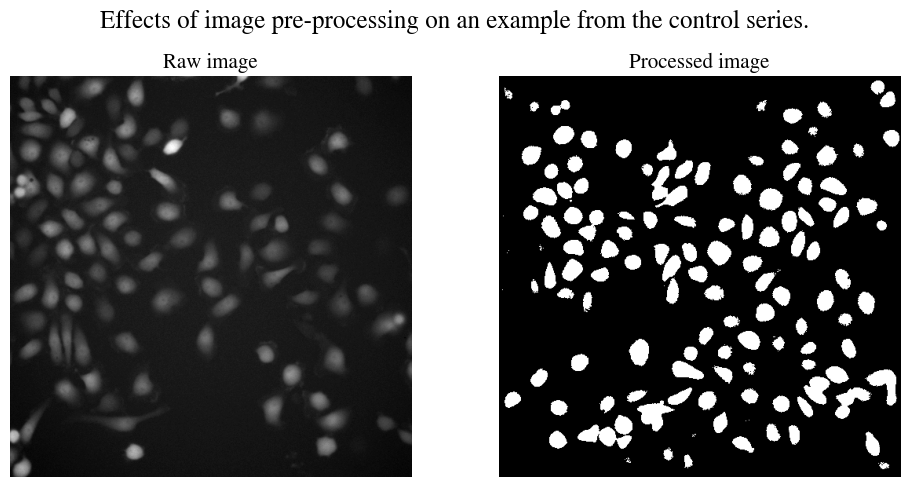

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
img = dip.ImageReadTIFF('images/MTLn3-ctrl0000.tif')
img = img / 2 ** 16
axs[0].imshow(img, origin='lower', cmap='grey')
axs[0].set_title('Raw image', fontsize=15)
axs[1].imshow(segmented['egf'][0], origin='lower', cmap='grey')
axs[1].set_title('Processed image', fontsize=15)
[axs[i].axis('off') for i in range(len(axs))]
fig.suptitle('Effects of image pre-processing on an example from the control series.', fontsize=18)
plt.tight_layout()
plt.savefig('figures/preprocessing.png')

### Computing Accumulative Difference Images (ADIs)

In [6]:
R = images['ctrl'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['ctrl'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

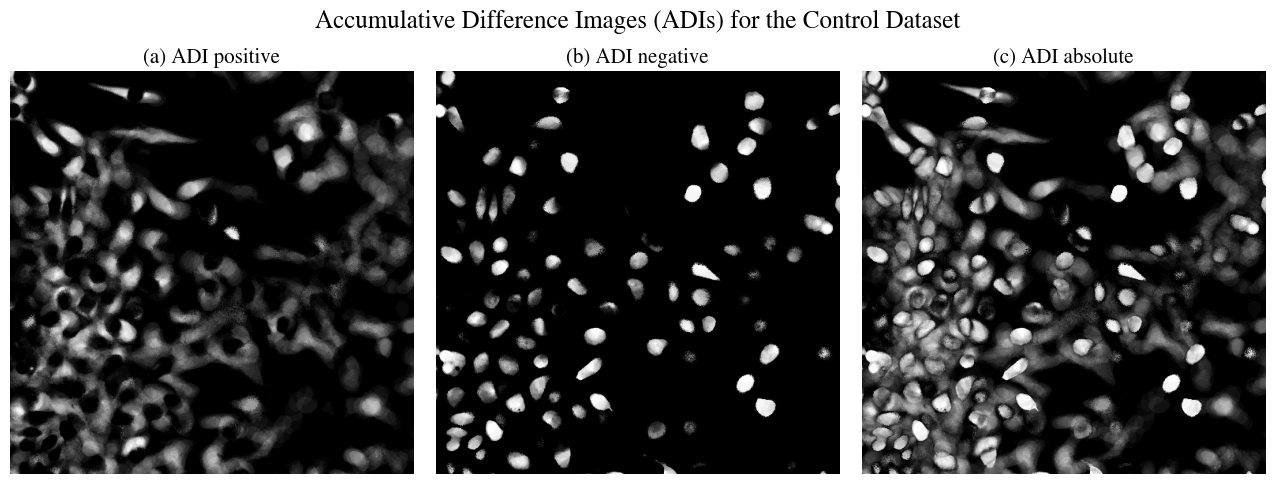

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(13, 5))
axs[0].imshow(adi_pos, cmap='grey')
axs[0].set_title('(a) ADI positive', fontsize=15)
axs[1].imshow(adi_neg, cmap='grey')
axs[1].set_title('(b) ADI negative', fontsize=15)
axs[2].imshow(adi_pos + adi_neg, cmap='grey')
axs[2].set_title('(c) ADI absolute', fontsize=15)

[axs[i].axis('off') for i in range(3)]
fig.suptitle('Accumulative Difference Images (ADIs) for the Control Dataset', fontsize=18)
plt.tight_layout()
plt.savefig('figures/adis.png')

### Cell selection

In [8]:
seed = np.zeros((512, 512))
for coord in initial_coords:
    seed[coord[1], coord[0]] = 1
seed = dip.FixedThreshold(seed, 0.5)
masked = dip.BinaryPropagation(seed, segmented['ctrl'][0])
labeled = dip.Label(masked, connectivity=1)
msr = dip.MeasurementTool.Measure(labeled, images['ctrl'][0], ['Gravity'])
cells = {i+1: [int(msr[i+1]['Gravity'][0]), int(msr[i+1]['Gravity'][1])] for i in range(msr.NumberOfObjects())}
labeled[labeled > 0] = 1

seed = np.zeros((512, 512))
for coord in coords_egf:
    seed[coord[1], coord[0]] = 1
seed = dip.FixedThreshold(seed, 0.5)
masked = dip.BinaryPropagation(seed, segmented['egf'][0])
labeled_egf = dip.Label(masked, connectivity=1)
msr = dip.MeasurementTool.Measure(labeled_egf, images['egf'][0], ['Gravity'])
cells_egf = {i+1: [int(msr[i+1]['Gravity'][0]), int(msr[i+1]['Gravity'][1])] for i in range(msr.NumberOfObjects())}
labeled_egf[labeled_egf > 0] = 1

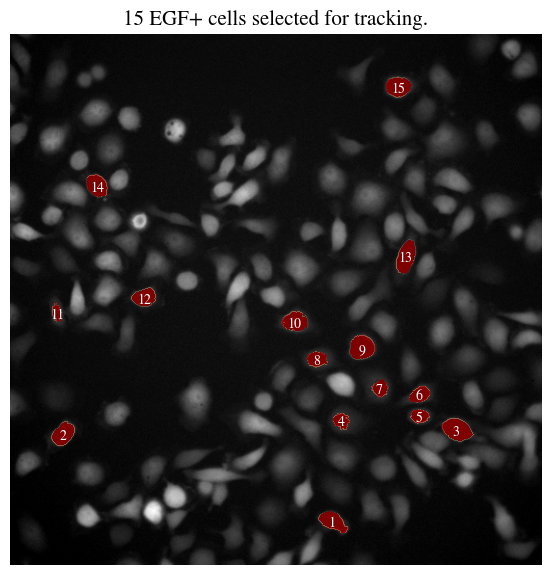

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images['egf'][0], cmap='grey')
ax.imshow(labeled_egf, alpha=1.0*(labeled_egf>0), cmap='OrRd', origin='lower')
ax.axis('off')
ax.set_title('15 EGF+ cells selected for tracking.', fontsize=15)
for k in cells_egf.keys():
    annot_offset = 3
    if k > 9:
        annot_offset = 6
    ax.annotate(text=k, xy=(cells_egf[k][0] - annot_offset, cells_egf[k][1] - 5), c='w', fontsize=10)
plt.tight_layout()
plt.savefig('figures/selected_cells_egf.png')

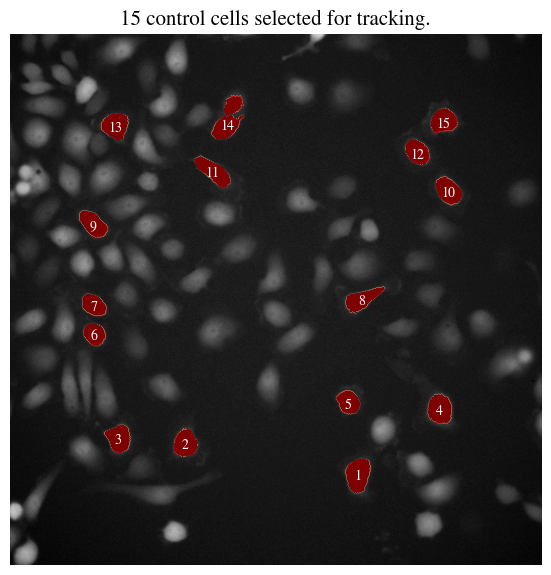

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(images['ctrl'][0], cmap='grey')
ax.imshow(labeled, alpha=1.0*(labeled>0), cmap='OrRd', origin='lower')
ax.axis('off')
ax.set_title('15 control cells selected for tracking.', fontsize=15)
for k in cells.keys():
    annot_offset = 3
    if k > 9:
        annot_offset = 6
    ax.annotate(text=k, xy=(cells[k][0] - annot_offset, cells[k][1] - 5), c='w', fontsize=10)
plt.tight_layout()
plt.savefig('figures/selected_cells.png')

### Cell tracking

In [11]:
tracked_cells = {}
for i in trange(len(initial_coords)):
    labeled_archive, x_coords, y_coords, sizes = track_cell(images['ctrl'], segmented['ctrl'], initial_coords[i])
    tracked_cells[i] = {
        'labeled': labeled_archive,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'sizes': sizes
    }

100%|██████████| 15/15 [00:03<00:00,  4.48it/s]


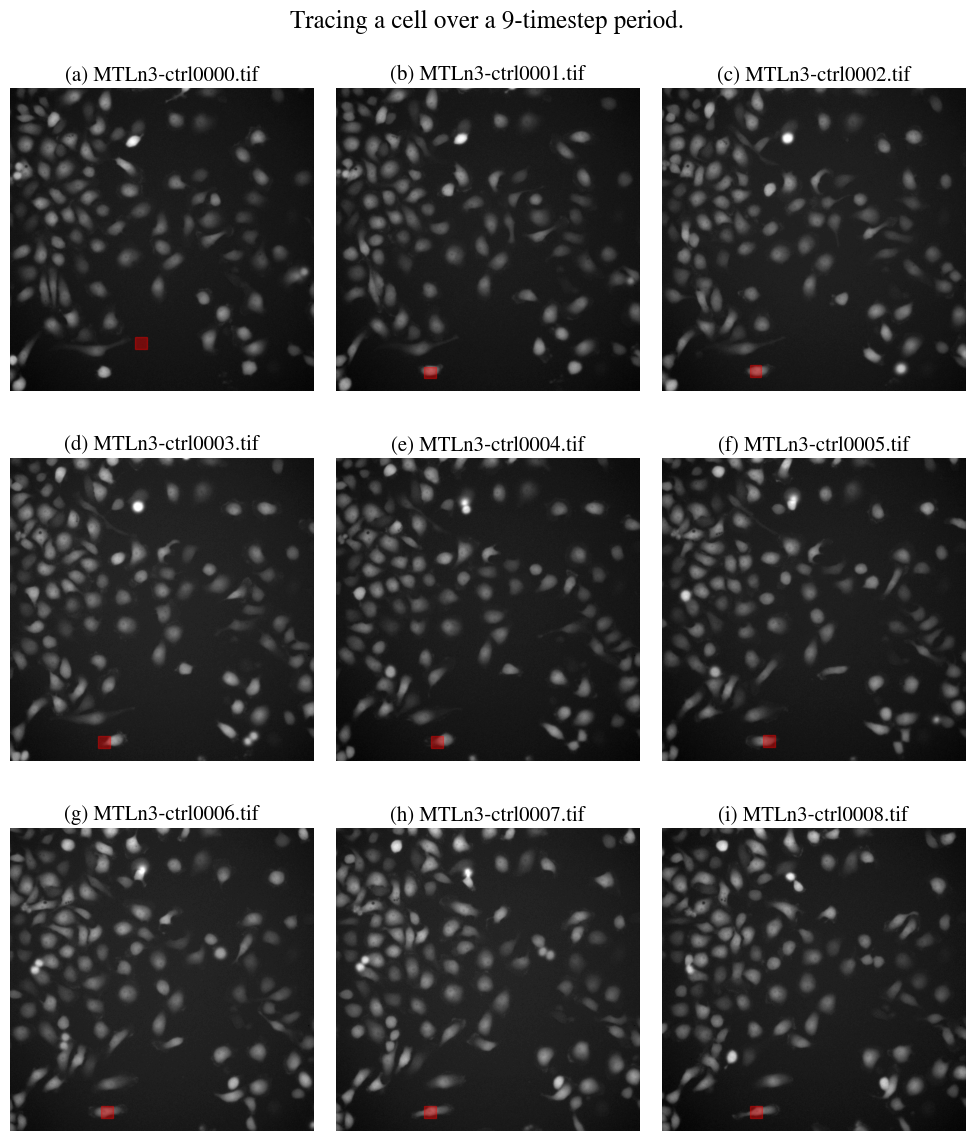

In [12]:
subcaps = string.ascii_lowercase[:9]
fig, axs = plt.subplots(3, 3, figsize=(10, 12))
axs = axs.flatten()
x_coords = tracked_cells[1]['x_coords']
y_coords = tracked_cells[1]['y_coords']
for i in range(len(axs)):
    axs[i].imshow(images['ctrl'][i], origin='lower', cmap='grey')
    rect = Rectangle(xy=(y_coords[i] - 10, x_coords[i] - 10), width=20, height=20, color='r', alpha=0.4)
    axs[i].add_patch(rect)
    axs[i].axis('off')
    num = i if i > 9 else f'0{i}'
    axs[i].set_title(f'({subcaps[i]}) MTLn3-ctrl00{num}.tif', fontname='STIXGeneral', fontsize=15)

fig.suptitle('Tracing a cell over a 9-timestep period.', fontname='STIXGeneral', fontsize=18)
plt.tight_layout()
plt.savefig('figures/single_cell_trace.png')

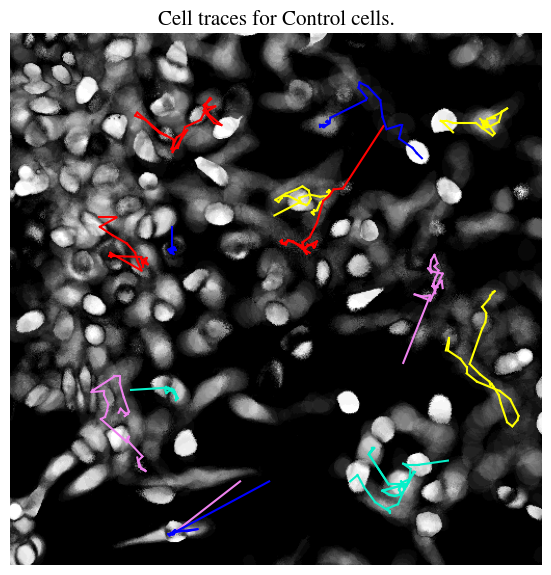

In [13]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9']
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(adi_pos+adi_neg, origin='lower', cmap='gray')
for i in range(15):
    x_coords = tracked_cells[i]['x_coords']
    y_coords = tracked_cells[i]['y_coords']
    for j in range(len(x_coords) - 1):
        ax.plot([y_coords[j], y_coords[j+1]], [x_coords[j], x_coords[j+1]], c=colors[i%len(colors)])
ax.axis('off')
ax.set_title('Cell traces for Control cells.', fontsize=15)
plt.tight_layout()
plt.savefig('figures/cell_tracking.png')

### Tracking the experimental series (EGF+)

In [14]:
tracked_cells_egf = {}
for i in trange(len(coords_egf)):
    labeled_archive, x_coords, y_coords, sizes = track_cell(images['egf'], segmented['egf'], coords_egf[i])
    tracked_cells_egf[i] = {
        'labeled': labeled_archive,
        'x_coords': x_coords,
        'y_coords': y_coords,
        'sizes': sizes
    }

100%|██████████| 15/15 [00:03<00:00,  4.32it/s]


In [15]:
R = images['egf'][0]
adi_pos = np.zeros((512, 512))
adi_neg = np.zeros((512, 512))

for i in range(30):
    grad = images['egf'][i] - R
    grad_pos, grad_neg = np.copy(grad), np.copy(grad)
    grad_pos[grad_pos > 0.01] = 1
    grad_pos[grad_pos <= 0.01] = 0
    grad_neg[grad_neg >= -0.01] = 0
    grad_neg[grad_neg < -0.01] = 1
    adi_pos += grad_pos
    adi_neg += grad_neg

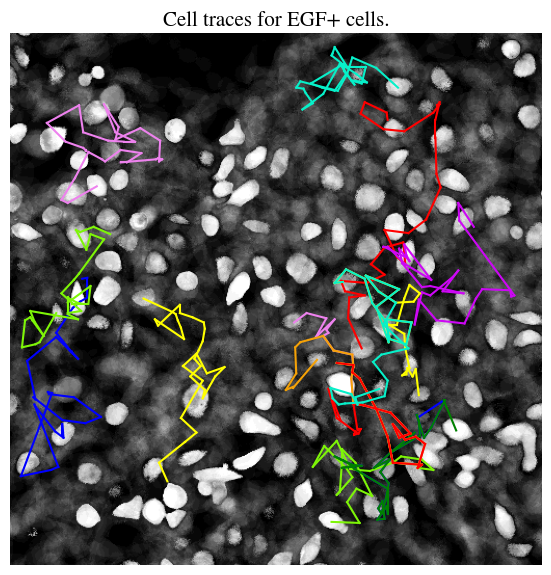

In [17]:
colors = ['r', 'violet', 'b', 'yellow', '#07f0c9', '#7ef507', 'g', '#cd07f5', '#f5a207']
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(adi_neg+adi_pos, origin='lower', cmap='gray')
for i in range(len(coords_egf)):
    x_coords = tracked_cells_egf[i]['x_coords']
    y_coords = tracked_cells_egf[i]['y_coords']
    for j in range(len(x_coords) - 1):
        ax.plot([x_coords[j], x_coords[j+1]], [y_coords[j], y_coords[j+1]], c=colors[i%len(colors)])
ax.axis('off')
ax.set_title('Cell traces for EGF+ cells.', fontsize=15)
plt.tight_layout()
plt.savefig('figures/cell_tracking_egf.png')

# Part 2

In [18]:
cells_data = {
    i: {'perimeter': [], 'size': [], 'area':[], 'roundness': [], 'coords': []} for i in tracked_cells_egf.keys()
}
for cell_id in tracked_cells_egf.keys():
    for timestep in range(len(tracked_cells_egf[cell_id]['labeled'])):
        msr = dip.MeasurementTool.Measure(tracked_cells_egf[cell_id]['labeled'][timestep],
                                          images['egf'][0],
                                          ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])
        current_cell = np.array([tracked_cells_egf[cell_id]['x_coords'][timestep+1], tracked_cells_egf[cell_id]['y_coords'][timestep+1]])
        coords = np.array([msr['Gravity'][j+1] for j in range(msr.NumberOfObjects())])
        cell = np.argmin(np.sum(np.power(coords - current_cell, 2), axis=1)) + 1
        cells_data[cell_id]['perimeter'].append(msr[cell]['Perimeter'][0])
        cells_data[cell_id]['size'].append(msr[cell]['Size'][0])
        cells_data[cell_id]['area'].append(msr[cell]['SolidArea'][0])
        cells_data[cell_id]['roundness'].append(msr[cell]['Roundness'][0])
        cells_data[cell_id]['coords'].append(msr[cell]['Gravity'][0])

In [19]:
cells_data_ctrl = {
    i: {'perimeter': [], 'size': [], 'area':[], 'roundness': [], 'coords': []} for i in tracked_cells.keys()
}
for cell_id in tracked_cells.keys():
    for timestep in range(len(tracked_cells[cell_id]['labeled'])):
        msr = dip.MeasurementTool.Measure(tracked_cells[cell_id]['labeled'][timestep],
                                          images['egf'][0],
                                          ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])
        current_cell = np.array([tracked_cells[cell_id]['x_coords'][timestep+1], tracked_cells[cell_id]['y_coords'][timestep+1]])
        coords = np.array([msr['Gravity'][j+1] for j in range(msr.NumberOfObjects())])
        cell = np.argmin(np.sum(np.power(coords - current_cell, 2), axis=1)) + 1
        cells_data_ctrl[cell_id]['perimeter'].append(msr[cell]['Perimeter'][0])
        cells_data_ctrl[cell_id]['size'].append(msr[cell]['Size'][0])
        cells_data_ctrl[cell_id]['area'].append(msr[cell]['SolidArea'][0])
        cells_data_ctrl[cell_id]['roundness'].append(msr[cell]['Roundness'][0])
        cells_data_ctrl[cell_id]['coords'].append(msr[cell]['Gravity'][0])

In [20]:
p_names = ('perimeter', 'size', 'area', 'roundness')
parameters = {'ctrl': {p: {'mean': [], 'max': [], 'min': []} for p in p_names},
              'egf': {p: {'mean': [], 'max': [], 'min': []} for p in p_names}}

for p in p_names:
    vals = {'ctrl': [], 'egf': []}
    for i in cells_data.keys():
        vals['egf'].append(cells_data[i][p])
    for i in cells_data_ctrl.keys():
        vals['ctrl'].append(cells_data_ctrl[i][p])

    sizes = {k: np.array(vals[k]) for k in vals.keys()}
    means_ctrl = np.mean(vals['ctrl'], axis=0)
    mins_ctrl = np.min(vals['ctrl'], axis=0)
    maxs_ctrl = np.max(vals['ctrl'], axis=0)
    means = np.mean(vals['egf'], axis=0)
    mins = np.min(vals['egf'], axis=0)
    maxs = np.max(vals['egf'], axis=0)
    parameters['ctrl'][p]['mean'] = means_ctrl
    parameters['ctrl'][p]['min'] = mins_ctrl
    parameters['ctrl'][p]['max'] = maxs_ctrl
    parameters['egf'][p]['mean'] = means
    parameters['egf'][p]['min'] = mins
    parameters['egf'][p]['max'] = maxs

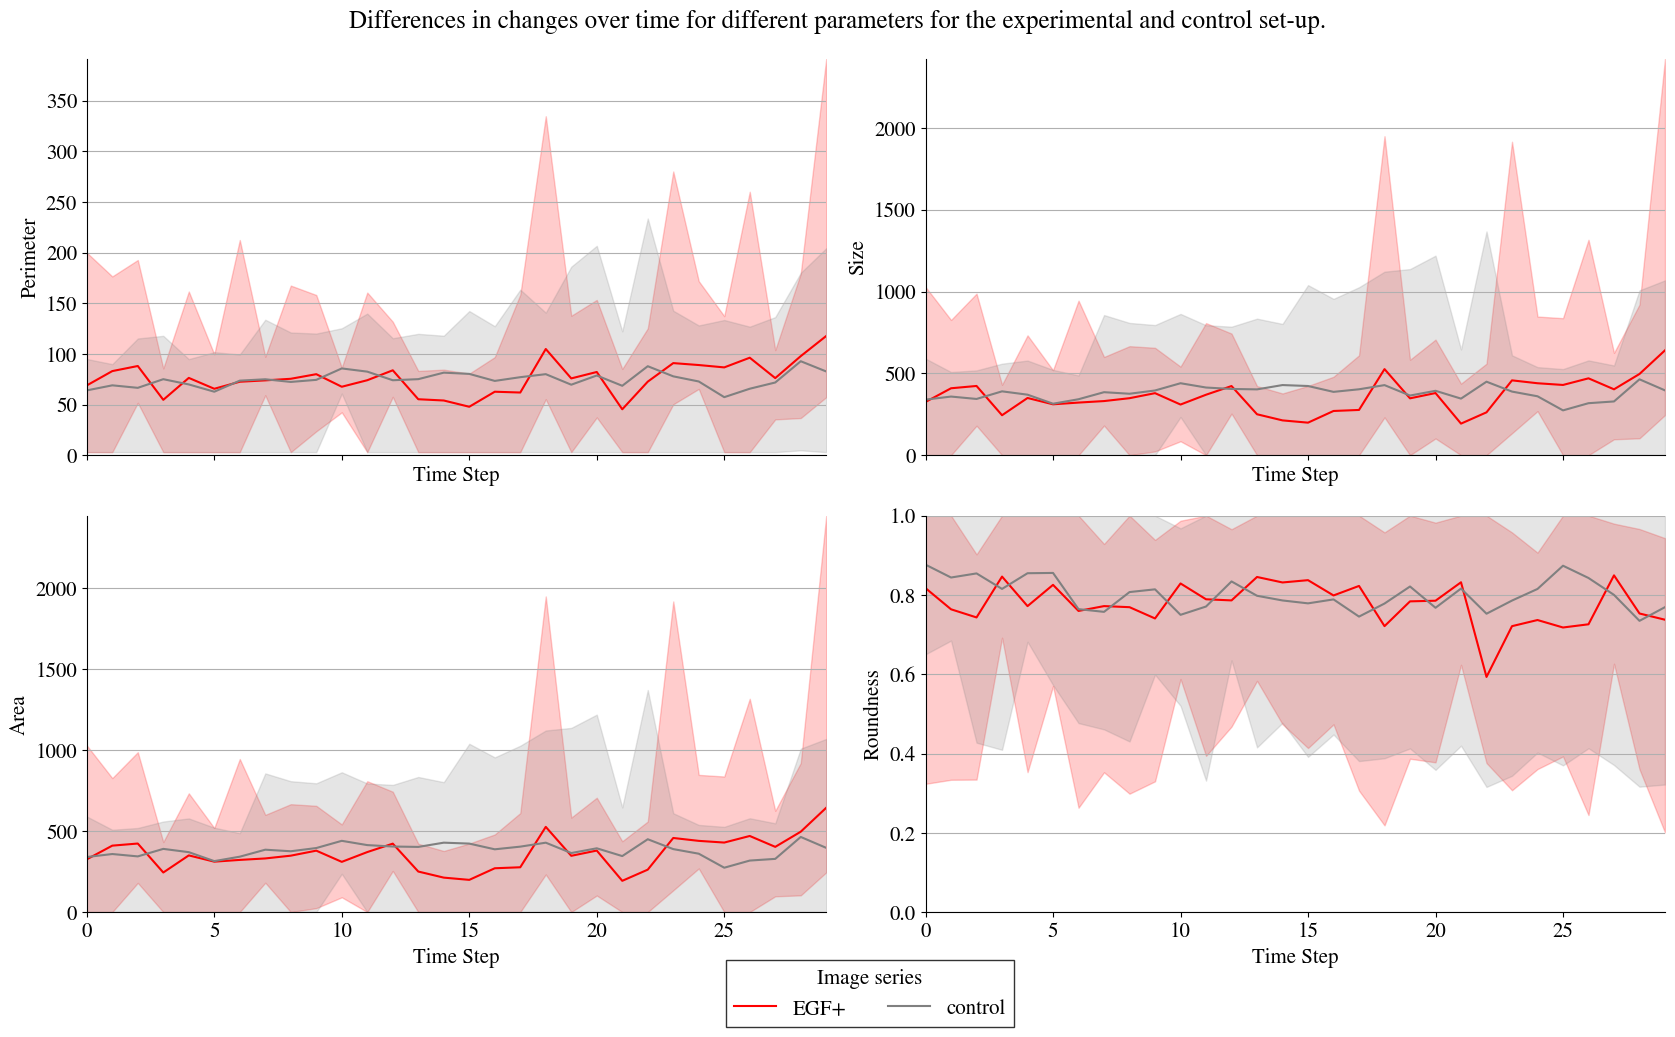

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10), sharex=True)
cs = ['r', 'gray']
axs = axs.flatten()
for idx, p in enumerate(p_names):
    axs[idx].plot(np.arange(30), parameters['egf'][p]['mean'], color=cs[0], label='EGF+')
    axs[idx].fill_between(np.arange(30), parameters['egf'][p]['min'], parameters['egf'][p]['max'], alpha=0.2, color=cs[0])
    axs[idx].plot(np.arange(30), parameters['ctrl'][p]['mean'], color=cs[1], label='control')
    axs[idx].fill_between(np.arange(30), parameters['ctrl'][p]['min'], parameters['ctrl'][p]['max'], alpha=0.2, color=cs[1])
    axs[idx].spines[['right', 'top']].set_visible(False)
    axs[idx].set_xlim(xmin=0, xmax=29)
    axs[idx].set_ylim(ymin=0, ymax=np.max([parameters['egf'][p]['max'].max(), parameters['ctrl'][p]['max'].max()]))
    axs[idx].grid(axis='y', zorder=0)
    axs[idx].set_xlabel('Time Step')
    axs[idx].set_ylabel(f'{p.title()}')

fig.legend(*axs[-1].get_legend_handles_labels(), title='Image series',
           ncols=2, alignment='center', bbox_to_anchor=(0.61, 0.04), fancybox=False, frameon=True,
           edgecolor='k')
plt.suptitle('Differences in changes over time for different parameters for the experimental and control set-up.')

plt.tight_layout()
plt.savefig('figures/parameter_change.png', bbox_inches='tight')

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

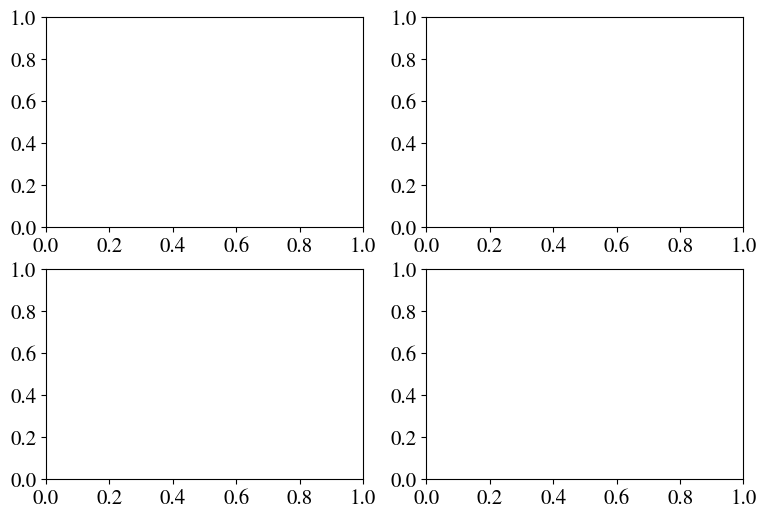

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(9, 6))
cs = ['#0d7cb8', 'g']
cs = ['r', 'grey']
ax.plot(np.arange(30), means, color=cs[0], label='EGF+')
ax.fill_between(np.arange(30), mins, maxs, alpha=0.2, color=cs[0])
ax.plot(np.arange(30), means_ctrl, color=cs[1], label='control')
ax.fill_between(np.arange(30), mins_ctrl, maxs_ctrl, alpha=0.2, color=cs[1])
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(xmin=0, xmax=29)
ax.set_ylim(ymin=0, ymax=2500)
ax.grid(axis='y', zorder=0)
ax.legend(title='Image series', alignment='left', bbox_to_anchor=(0.2, 0.98), frameon=True, ncol=1,
          edgecolor='k', facecolor='w', framealpha=1, fancybox=False)
ax.set_title('Change of cells area over time for different experimental conditions.')
ax.set_xlabel('Time Step')
ax.set_ylabel('Area [px]')
plt.tight_layout()
plt.savefig('figures/size_change.png')

In [22]:
control_df = process_cells_data(cells_data_ctrl)
egf_df = process_cells_data(cells_data)

# Display the dataframes
print("Control condition features:")
print(control_df)

print("\nEGF condition features:")
print(egf_df)


Control condition features:
    Cell ID  Mean perimeter   Mean size   Mean area  Mean roundness
0         0       62.591793  298.200000  298.566667        0.843854
1         1      113.737159  492.566667  492.633333        0.521493
2         2      113.858726  492.866667  492.933333        0.519485
3         3       84.440026  434.266667  434.466667        0.759497
4         4      110.174726  692.000000  692.166667        0.759838
5         5       76.655493  409.500000  409.800000        0.854689
6         6       86.436426  453.200000  453.633333        0.758250
7         7       59.764359  276.233333  276.233333        0.914332
8         8       80.196493  465.133333  465.133333        0.912188
9         9       73.261593  387.800000  387.900000        0.873155
10       10        9.493426   25.333333   25.633333        0.970220
11       11       43.529793  167.366667  168.066667        0.819604
12       12       45.782593  228.800000  228.866667        0.907267
13       13       50

In [23]:
msr = dip.MeasurementTool.Measure(tracked_cells_egf[1]['labeled'][2],
                                    images['egf'][0],
                                    ['Gravity', 'Size', 'Roundness', 'SolidArea', 'Perimeter'])

In [24]:
print(msr)

  |                 Gravity |       Size |  Roundness |  SolidArea |  Perimeter | 
- | ----------------------- | ---------- | ---------- | ---------- | ---------- | 
  |       dim0 |       dim1 |            |            |            |            | 
  |       (px) |       (px) |      (px²) |            |      (px²) |       (px) | 
- | ---------- | ---------- | ---------- | ---------- | ---------- | ---------- | 
1 |      219.9 |      294.6 |      333.0 |     0.8128 |      333.0 |      71.75 | 
2 |      281.2 |      313.1 |      988.0 |     0.3344 |      988.0 |      192.7 | 



### 2.4.6

In [29]:
speed_dic = {}
distances_dic = {}
for cell_index in range(0, len(tracked_cells_egf)):
    x_coords = tracked_cells_egf[cell_index]['x_coords']
    y_coords = tracked_cells_egf[cell_index]['y_coords']
    speed, distances = calculate_speed(x_coords, y_coords)
    speed_dic[cell_index] = speed
    distances_dic[cell_index] = np.sum(distances) 

# df for table
df = pd.DataFrame({
    'Cell ID': list(speed_dic.keys()),
    'Speed (units/minute)': list(speed_dic.values()),
    'distance trajectory (units)': list(distances_dic.values())
})

print(df)

    Cell ID  Speed (units/minute)  distance trajectory (units)
0         0              9.303756                   558.225371
1         1              8.238203                   494.292202
2         2              8.375255                   502.515307
3         3              8.261308                   495.678462
4         4              8.446823                   506.809363
5         5              9.802230                   588.133789
6         6              8.417593                   505.055607
7         7             10.792218                   647.533093
8         8              8.498318                   509.899070
9         9              7.310314                   438.618845
10       10              8.916840                   535.010375
11       11             10.085321                   605.119269
12       12              8.873573                   532.414393
13       13              9.867696                   592.061745
14       14              8.216916                   493

In [30]:
speed_dic_ctrl = {}
distances_dic_ctrl = {}
for cell_index in range(len(tracked_cells_egf)):
    x_coords = tracked_cells_egf[cell_index]['x_coords']
    y_coords = tracked_cells_egf[cell_index]['y_coords']
    speed, distances = calculate_speed(x_coords, y_coords)
    speed_dic_ctrl[cell_index] = speed
    distances_dic_ctrl[cell_index] = np.sum(distances)

df_ctrl = pd.DataFrame({
    'Cell ID': list(speed_dic_ctrl.keys()),
    'Speed (units/minute)': list(speed_dic_ctrl.values()),
    'distance trajectory (units)': list(distances_dic_ctrl.values())
})

print(df_ctrl)

    Cell ID  Speed (units/minute)  distance trajectory (units)
0         0              9.303756                   558.225371
1         1              8.238203                   494.292202
2         2              8.375255                   502.515307
3         3              8.261308                   495.678462
4         4              8.446823                   506.809363
5         5              9.802230                   588.133789
6         6              8.417593                   505.055607
7         7             10.792218                   647.533093
8         8              8.498318                   509.899070
9         9              7.310314                   438.618845
10       10              8.916840                   535.010375
11       11             10.085321                   605.119269
12       12              8.873573                   532.414393
13       13              9.867696                   592.061745
14       14              8.216916                   493

### 2.4.7

In [115]:
# calculate some statistics to compare the trajectories of the two conditions
speed_mean_egf, speed_std_egf, distance_mean_egf, distance_std_egf = calculate_statistics(speed_dic, distances_dic)

speed_mean_ctrl, speed_std_ctrl, distance_mean_ctrl, distance_std_ctrl = calculate_statistics(speed_dic_ctrl, distances_dic_ctrl)

print("Control Condition Statistics:")
print(f"Mean Speed: {speed_mean_ctrl:.2f} units/minute, speed st. dev: {speed_std_ctrl:.2f}")
print(f"mean distance: {distance_mean_ctrl:.2f} units, distance st. dev: {distance_std_ctrl:.2f}")

print("\nEGF statistics:")
print(f"Mean speed: {speed_mean_egf:.2f} units/minute, speed st. dev: {speed_std_egf:.2f}")
print(f"mean distance: {distance_mean_egf:.2f} units, distance st. dev: {distance_std_egf:.2f}")

Control Condition Statistics:
Mean Speed: 3.37 units/minute, speed st. dev: 1.15
mean distance: 201.99 units, distance st. dev: 68.82

EGF statistics:
Mean speed: 8.17 units/minute, speed st. dev: 1.58
mean distance: 490.27 units, distance st. dev: 94.84


### 2.4.8

In [113]:
feature_stats_egf = calculate_feature_statistics(cells_data)
feature_stats_ctrl = calculate_feature_statistics(cells_data_ctrl)

print("EGF feature statistics:")
for feature, value in feature_stats_egf.items():
    print(f"{feature}: {value:.2f}")

print("\ncontrol feature statistics:")
for feature, value in feature_stats_ctrl.items():
    print(f"{feature}: {value:.2f}")


EGF feature statistics:
perimeter mean: 76.40
perimeter st. dev: 8.03
size mean: 367.52
size st. dev: 47.88
area mean: 367.79
area st. dev: 47.87
roundness mean: 0.78
roundness st. dev: 0.02

control feature statistics:
perimeter mean: 66.45
perimeter st. dev: 36.25
size mean: 322.10
size st. dev: 191.49
area mean: 322.24
area st. dev: 191.42
roundness mean: 0.81
roundness st. dev: 0.16


### 2.4.9

In [103]:
df_egf_correlation = prepare_data(cells_data, speed_dic)
df_ctrl_correlation = prepare_data(cells_data_ctrl, speed_dic_ctrl)

# correlation
correlation_matrix_egf = df_egf_correlation.corr()
correlation_matrix_ctrl = df_ctrl_correlation.corr()

print("control correlation matrix:")
print(correlation_matrix_ctrl)

print("\nEGF correlation matrix:")
print(correlation_matrix_egf)

control correlation matrix:
              speed  perimeter      size      area  roundness
speed      1.000000  -0.334913 -0.283717 -0.283316   0.132469
perimeter -0.334913   1.000000  0.958706  0.958668  -0.851673
size      -0.283717   0.958706  1.000000  1.000000  -0.696905
area      -0.283316   0.958668  1.000000  1.000000  -0.696927
roundness  0.132469  -0.851673 -0.696905 -0.696927   1.000000

EGF correlation matrix:
              speed  perimeter      size      area  roundness
speed      1.000000   0.306433  0.253255  0.255028  -0.083430
perimeter  0.306433   1.000000  0.939704  0.940197  -0.686955
size       0.253255   0.939704  1.000000  0.999995  -0.482506
area       0.255028   0.940197  0.999995  1.000000  -0.483574
roundness -0.083430  -0.686955 -0.482506 -0.483574   1.000000
